In [ ]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install

    install()
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

In [ ]:
import cell2location
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42  # enables correct plotting of text for PDFs

INFO:lightning_fabric.utilities.seed:Global seed set to 0
/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [ ]:
results_folder = "./results/"

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f"{results_folder}/reference_signatures"
run_name = f"{results_folder}/cell2location_map"

In [ ]:
sc_adata = sc.read_h5ad("BC_atlas_xe.h5ad")
st_adata = sc.read_h5ad("visium_roi.h5ad")

/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


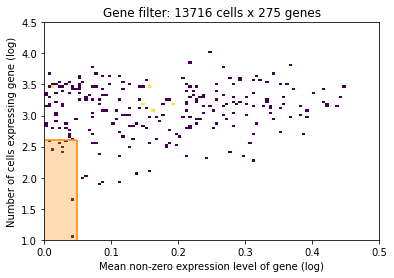

In [ ]:
from cell2location.utils.filtering import filter_genes

selected = filter_genes(sc_adata, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
sc_adata = sc_adata[:, selected].copy()

In [ ]:
cell2location.models.RegressionModel.setup_anndata(
    adata=sc_adata,
    # 10X reaction / sample / batch
    # batch_key='dataset',
    # cell type, covariate used for constructing signatures
    labels_key="celltype_major",
    # multiplicative technical effects (platform, 3' vs 5', donor effect)
    # categorical_covariate_keys=['Method']
)

In [ ]:
sc_adata.X = (np.around(np.exp(sc_adata.X.toarray())) + 1).astype(int)

In [ ]:
sc_adata.X = sc_adata.X.astype(int)

In [ ]:
from cell2location.models import RegressionModel

mod = RegressionModel(sc_adata)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': 'celltype_major',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 13716 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   9   │
│          n_vars          │  275  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                          labels State Registry                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location       ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype_major'] │      B-cells      │          0          │
│                             │       CAFs        │          1          │
│                             │ Cancer Epithelial │          2          │
│                             │    Endothelial    │          3          │
│                             │      Myeloid      │          4          │
│                             │ Normal Epithelial │          5          │
│                             │        PVL        │          6          │
│                             │   Plasmablasts    │          7          │
│                             │      T-cells      │          8          │
└─────────────────────────────┴───────────────────┴─────────────────────┘

In [ ]:
mod.train(max_epochs=250, use_gpu=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Epoch 250/250: 100%|██████████| 250/250 [00:53<00:00,  2.13it/s, v_num=1, elbo_train=7.22e+6]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [00:53<00:00,  4.64it/s, v_num=1, elbo_train=7.22e+6]


In [ ]:
sc_adata = mod.export_posterior(sc_adata, sample_kwargs={"num_samples": 1000, "batch_size": 2500, "use_gpu": True})

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
sc_adata.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:08<00:00, 124.84it/s]


'./results//reference_signatures/sc.h5ad'

In [ ]:
sc_adata = mod.export_posterior(
    sc_adata,
    use_quantiles=True,
    # choose quantiles
    # add_to_obsm=["q05","q50", "q95", "q0001"],
    sample_kwargs={"batch_size": 2500, "use_gpu": True},
)

In [ ]:
if "means_per_cluster_mu_fg" in sc_adata.varm.keys():
    inf_aver = sc_adata.varm["means_per_cluster_mu_fg"][
        [f"means_per_cluster_mu_fg_{i}" for i in sc_adata.uns["mod"]["factor_names"]]
    ].copy()
else:
    inf_aver = sc_adata.var[[f"means_per_cluster_mu_fg_{i}" for i in sc_adata.uns["mod"]["factor_names"]]].copy()
inf_aver.columns = sc_adata.uns["mod"]["factor_names"]
inf_aver.iloc[0:5, 0:5]

,B-cells,CAFs,Cancer Epithelial,Endothelial,Myeloid
MMRN2,0.033889,0.127952,0.038615,0.874916,0.001506
KRT6B,0.138106,0.090885,0.408698,0.040359,0.074984
TMEM147,0.510232,0.568958,0.754650,0.609991,0.608777
MAP3K8,0.721416,0.497620,0.490398,0.577397,0.727202
SFRP1,0.139716,0.530988,0.443823,0.216514,0.081829


In [ ]:
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

In [ ]:
inf_aver

,B-cells,CAFs,Cancer Epithelial,Endothelial,Myeloid,Normal Epithelial,PVL,Plasmablasts,T-cells
MMRN2,0.033889,0.127952,0.038615,0.874916,0.001506,0.138810,0.241233,0.047582,0.031352
KRT6B,0.138106,0.090885,0.408698,0.040359,0.074984,0.616140,0.060105,0.001926,0.014741
TMEM147,0.510232,0.568958,0.754650,0.609991,0.608777,0.586867,0.571475,0.593307,0.510665
MAP3K8,0.721416,0.497620,0.490398,0.577397,0.727202,0.547423,0.486622,0.457617,0.679271
SFRP1,0.139716,0.530988,0.443823,0.216514,0.081829,1.045137,0.143442,0.039269,0.053131
...,...,...,...,...,...,...,...,...,...
GATA3,0.184712,0.214619,0.965957,0.280195,0.257746,0.748428,0.310583,0.233299,0.590538
IL2RG,0.820242,0.143341,0.181468,0.352879,0.591483,0.160338,0.199137,0.553898,1.411410
CTTN,0.091402,0.525401,0.485756,0.513728,0.143474,0.433365,0.469126,0.197443,0.151885
IGF1,0.098642,1.676108,0.063320,0.328813,0.350709,0.089618,0.099137,0.382529,0.051443


In [ ]:
intersect = np.intersect1d(st_adata.var_names, inf_aver.index)
st_adata = st_adata[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [ ]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=st_adata)

In [ ]:
mod = cell2location.models.Cell2location(
    st_adata,
    cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=5,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20,
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 2829  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │  270  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Epoch 30000/30000: 100%|██████████| 30000/30000 [35:51<00:00, 15.24it/s, v_num=1, elbo_train=1.13e+6]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [35:51<00:00, 13.94it/s, v_num=1, elbo_train=1.13e+6]


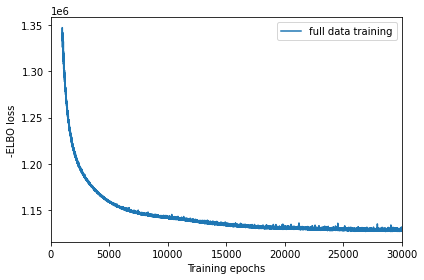

In [ ]:
mod.train(
    max_epochs=30000,
    # train using full data (batch_size=None)
    batch_size=None,
    # use all data points in training because
    # we need to estimate cell abundance at all locations
    train_size=1,
    use_gpu=True,
)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=["full data training"]);

In [ ]:
st_adata = mod.export_posterior(
    st_adata, sample_kwargs={"num_samples": 1000, "batch_size": mod.adata.n_obs, "use_gpu": True}
)

Sampling global variables, sample: 100%|██████████| 999/999 [00:17<00:00, 56.32it/s]


In [ ]:
st_adata.obsm["q95_cell_abundance_w_sf"].columns = [x[23:] for x in st_adata.obsm["q95_cell_abundance_w_sf"].columns]

In [ ]:
st_adata.obs[st_adata.uns["mod"]["factor_names"]] = st_adata.obsm["q05_cell_abundance_w_sf"]

In [ ]:
st_adata.write("visium_annotated_cell2location.h5ad")

In [ ]:
from cell2location.plt import plot_spatial

clust_labels = ["Myeloid", "Cancer Epithelial", "Normal Epithelial", "T-cells", "CAFs", "B-cells", "Endothelial"]
clust_col = ["Myeloid", "Cancer Epithelial", "Normal Epithelial", "T-cells", "CAFs", "T-cells", "Endothelial"]
import matplotlib as mpl

with mpl.rc_context({"figure.figsize": (20, 15)}):
    fig = plot_spatial(
        adata=st_adata,
        # labels to show on a plot
        color=clust_col,
        labels=clust_labels,
        show_img=False,
        # 'fast' (white background) or 'dark_background'
        style="fast",
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=10,
        colorbar_position="right",
        white_spacing=20,
        adjust_text=True,
    )

# plt.pyplot.savefig('results/visium_streoscope_major_spots.pdf')

In [ ]:
sc_adata.layers["counts"] = sc_adata.X.copy()
st_adata.layers["counts"] = st_adata.X.copy()
# sc.pp.normalize_total(st_adata, target_sum=1e5)
# sc.pp.log1p(st_adata)

sc_adata.raw = sc_adata

In [ ]:
RNAStereoscope.setup_anndata(sc_adata, layer="counts", labels_key="celltype_major")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|██████████| 100/100 [02:35<00:00,  1.40s/it, loss=5.59e+04, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it, loss=5.59e+04, v_num=1]


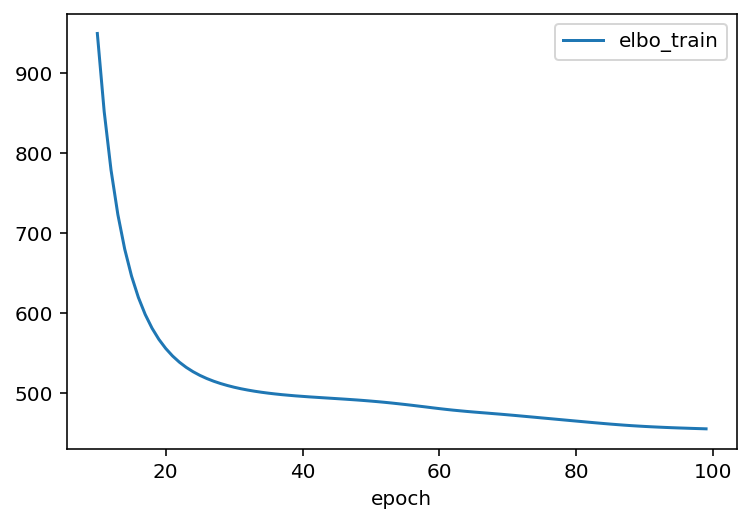

In [ ]:
train = True
if train:
    sc_model = RNAStereoscope(sc_adata)
    sc_model.train(max_epochs=100)
    sc_model.history["elbo_train"][10:].plot()
    sc_model.save("scmodel", overwrite=True)
else:
    sc_model = RNAStereoscope.load("scmodel", adata=sc_adata)
    print("Loaded RNA model from file!")

In [ ]:
SpatialStereoscope.setup_anndata(st_adata, layer="counts")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 2000/2000: 100%|██████████| 2000/2000 [12:51<00:00,  2.07it/s, loss=1.19e+06, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 2000/2000: 100%|██████████| 2000/2000 [12:51<00:00,  2.59it/s, loss=1.19e+06, v_num=1]


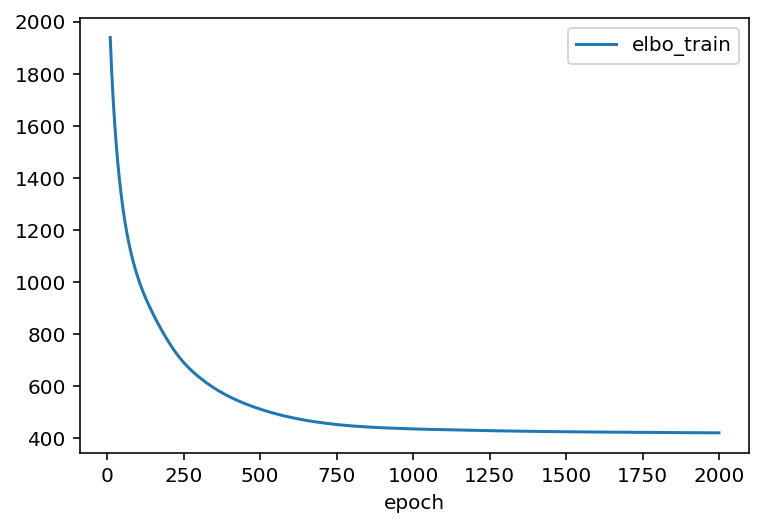

In [ ]:
train = True
if train:
    spatial_model = SpatialStereoscope.from_rna_model(st_adata, sc_model)
    spatial_model.train(max_epochs=2000)
    spatial_model.history["elbo_train"][10:].plot()
    spatial_model.save("stmodel", overwrite=True)
else:
    spatial_model = SpatialStereoscope.load("stmodel", adata=st_adata)
    print("Loaded Spatial model from file!")

In [ ]:
st_adata.obsm["streoscope_major"] = spatial_model.get_proportions()

# also copy as single field in the anndata for visualization
for ct in st_adata.obsm["streoscope_major"].columns:
    st_adata.obs[ct] = st_adata.obsm["streoscope_major"][ct]

In [ ]:
st_adata

AnnData object with n_obs × n_vars = 2829 × 302
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'dataset', 'ROI', 'n_counts', '_indices', 'B cells Memory', 'B cells Naive', 'CAFs MSC iCAF-like', 'CAFs myCAF-like', 'Cancer Basal SC', 'Cancer Cycling', 'Cancer Her2 SC', 'Cancer LumA SC', 'Cancer LumB SC', 'Cycling PVL', 'Cycling T-cells', 'Cycling_Myeloid', 'DCs', 'Endothelial ACKR1', 'Endothelial CXCL12', 'Endothelial Lymphatic LYVE1', 'Endothelial RGS5', 'Luminal Progenitors', 'Macrophage', 'Mature Luminal', 'Monocyte', 'Myoepithelial', 'NK cells', 'NKT cells', 'PVL Differentiated', 'PVL Immature', 'Plasmablasts', 'T cells CD4+', 'T cells CD8+', 'B-cells', 'CAFs', 'Cancer Epithelial', 'Endothelial', 'Myeloid', 'Normal Epithelial', 'PVL', 'T-cells'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialdata_attrs', 'wilcoxon', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'xe_rep1_celltype_major', 'xe_rep1_celltype_minor', 'xe_rep2_celltype_major', 'xe_rep2

In [ ]:
st_adata

In [ ]:
st_adata.write("visium_roi_streoscope.h5ad")
# st_adata.obsm['streoscope_major'].write('streoscope_visium_major.csv')

In [ ]:
# sc.settings.set_figure_params(
#     dpi=60, color_map="RdPu", dpi_save=200, vector_friendly=True, format="svg"
# )
# sc.pl.spatial(
#     st_adata,
#     img_key="hires",
#     color=["EC5_art", "EC6_ven"],
#     size=1.2,
#     color_map="inferno",
# )